In [1]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib2 import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from sklearn.externals import joblib


import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    file = urlopen(url)

    img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

In [4]:
#We can do this in 5 lines of code!
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d

In [87]:
#TODO remove all afkikea 
meta_path = 'trial.csv'
X = pd.read_csv(meta_path)
print X.shape

(15695, 2053)


In [88]:
X.product_id = X.product_id.astype(str)

In [7]:
X_afrikrea = X[X['product_id'].str.contains('afrikrea')]
print X_afrikrea.shape

(11194, 2053)


In [89]:
X_train = X[~X['product_id'].str.contains('afrikrea')]
X_train= X_train.reset_index(drop=True)

In [90]:
#X_train_conv_2d = X_train[[_ for _ in X_train.columns if "x_" in _]].values.astype(np.float)
X_train_conv_2d = X_train[[_ for _ in X_train.columns if "x_" in _]].values.astype(np.float)
X_train_conv_2d.shape

(4501, 2048)

In [55]:
J = pd.read_csv(meta_path, usecols=['filename', "gender", "category", "product_id"])
print J.shape

(15695, 4)


In [91]:
#Training KNN on 100K images w/ 2K features takes about 2 minutes!
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20, n_jobs=8, algorithm='ball_tree')
knn.fit(X_train_conv_2d)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=20, p=2, radius=1.0)

In [92]:
#serialize 
from sklearn.externals import joblib
knn_file = 'afronet_conv_feats.pkl'
joblib.dump(knn, knn_file)

['afronet_conv_feats.pkl']

In [93]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [94]:
# RUN FILE FROM HERE 

def get_neighbors(f, knn_file, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    delete_model(model)
    return neighbors

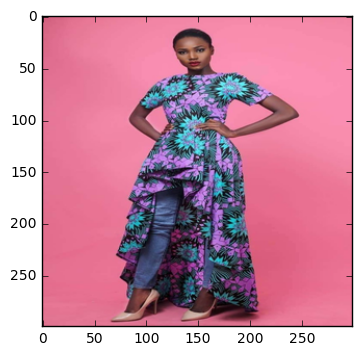

In [95]:
img_width, img_height = 299, 299
url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1MST6Z8Uafrikrea/01MST6Z8Uafrikrea.jpeg"
#url = '/Users/robelmengistu/Documents/CS230_project/data/women/women-jackets/1IURM78Safrikrea/21IURM78Safrikrea.jpeg'
#url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/11887377615/4african-print-wekesa-midi-dress.jpeg"
img = read_img(url) # reads an image link into a NumPy array...
n1p_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(n1p_img)

In [96]:
neighbors = get_neighbors(url, knn_file, top=8)

In [133]:
def plot_neighbors(url, neighbors, J, top=8, per_row=4):
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    path_split = url.split("/")
    #category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    #print "Query: ", category
    img = read_img(url) # reads an image link into a NumPy array...
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imshow(np_img)
    
    c = 0 
    i = 0 
    product_recommended = []
    while (True):
        if c == top: break 
        if c % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = c % 4
        k = neighbors[1][0][i]

        path = datadir + J['gender'][k] + "/" +J['category'][k]+ "/" +str (J['product_id'][k])+"/" + J['filename'][k]

        if not os.path.exists(path): 
            i += 1
            continue 
        image = read_img(path)
        if J['product_id'][k] in product_recommended: 
            i += 1
            continue
        i += 1
        c += 1
        product_recommended.append(J['product_id'][k])
        
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(J['category'][k] + "   "+ str(distance[i]),
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')
  

        

In [134]:
def get_accuracy(url, neighbors, J, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    query_category = path_split[7]
    #print "query: ", query_category
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
    accuracy = 0
    product_recommended = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        #print k, X_train['product_id'][k]
        if J['product_id'][k] in product_recommended: 
            i += 1
            continue
        if J['category'][k] == query_category: accuracy += 1.0/num_rec
        i += 1
        c += 1
        product_recommended.append(J['product_id'][k])
    return accuracy
        
        

In [103]:
print get_accuracy(url, neighbors, X_train, num_rec=8, per_row=4)
#plot_neighbors(url, neighbors, X_train, top=8, per_row=4)

query_category:  women-dresses
0.25


In [104]:
def get_neighbors_set(f_set, knn_file):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = get_conv_feats(f, model)
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    delete_model(model)
    return neighbors_set

In [67]:
#construct test set of 3k images from Afrikea...check error

In [69]:
# how to find filenames 
# TODO: change all product_ids to strings when saving
CATEGORY = 6
PRODUCT_ID = 8
FILE_NAME = 9

datadir = '/Users/robelmengistu/Documents/CS230_project/data'
i = 0
products_added = []
test_urls = []

for subdir, dirs, files in os.walk(datadir):
    for img in files:
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        product = path_split[PRODUCT_ID]
        if "afrikrea" in product and product not in products_added:
            products_added.append(product)
            test_urls.append(path)
        else: 
            continue 
        i += 1
print len(test_urls)

4181


In [123]:
dresses_set = test_urls[:450]
other_set = test_urls[2750:3200]  # pants and shorts and skirts

In [119]:
dress_neighbors_set = get_neighbors_set(dresses_set, knn_file)

In [125]:
other_neighbors_set = get_neighbors_set(other_set, knn_file)

In [138]:
dress_accuracy = 0 
acc_factor = 1.0/len(dresses_set)
for i in range(len(dresses_set)):
    if i == 324: 
        dress_accuracy += (0.5*acc_factor)
        continue
    acc = get_accuracy(dresses_set[i], dress_neighbors_set[i], X_train, num_rec=8, per_row=4)
    dress_accuracy += (acc*acc_factor)
    
print "Dress Accuracy: ", dress_accuracy

other_accuracy = 0 
acc_factor = 1.0/len(other_set)
for i in range(len(other_set)):
    acc = get_accuracy(other_set[i], other_neighbors_set[i], X_train, num_rec=8, per_row=4)

    other_accuracy += (acc*acc_factor)
    
print "Other Accuracy: ", other_accuracy
print "Overall", (other_accuracy + dress_accuracy)/2.0

Dress Accuracy:  0.476666666667
Other Accuracy:  0.204166666667
Overall 0.340416666667


In [ ]:
neighbors_set = get_neighbors_set(test_urls[:1000], knn_file)

0.375


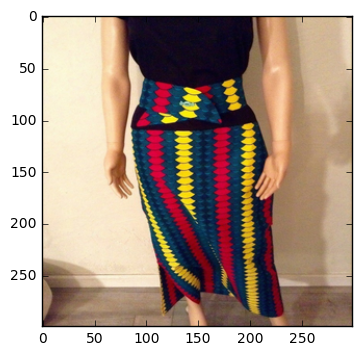

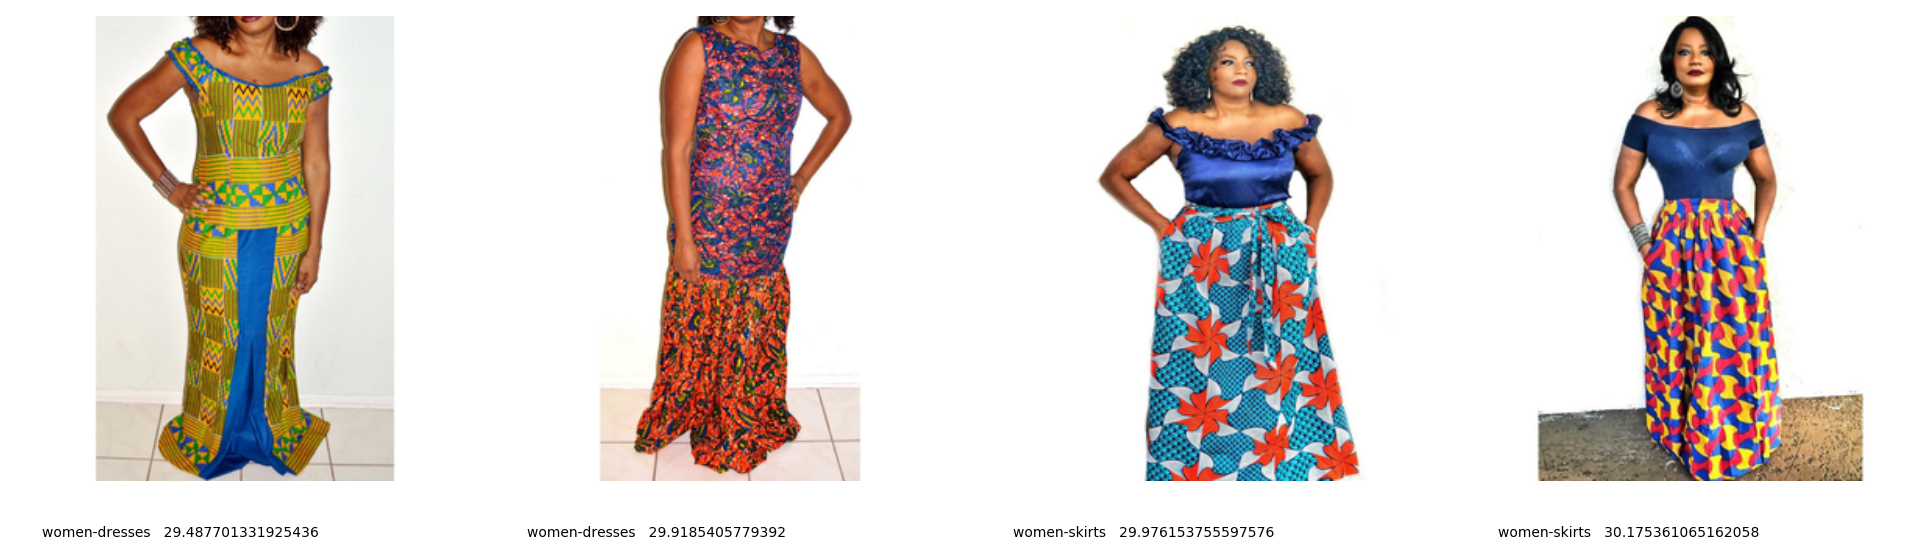

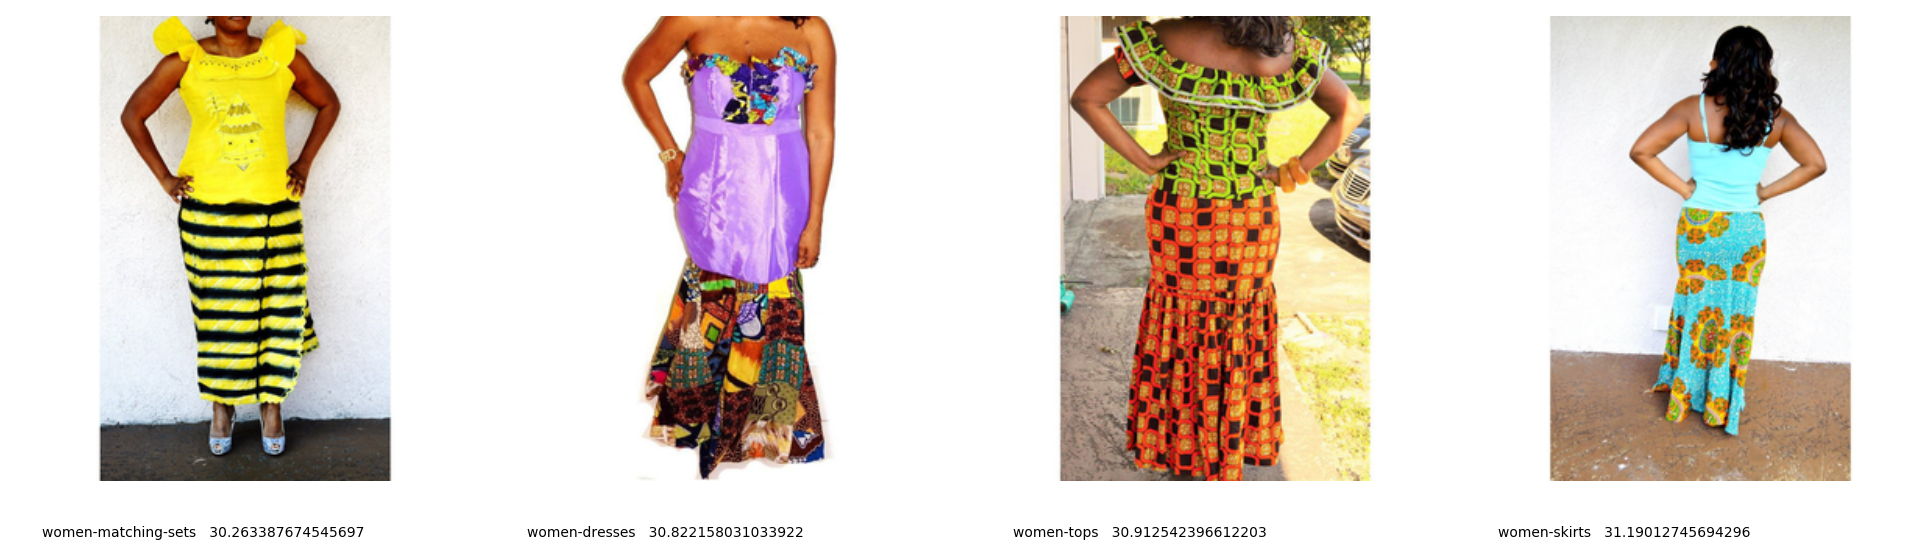

In [141]:
i = 3
print get_accuracy(test_urls[i], neighbors_set[i], X_train, num_rec=8, per_row=4)
plot_neighbors(test_urls[i], neighbors_set[i], X_train, top=8, per_row=4)